# 2.7 学習と検証の実施

- 本ファイルでは、SSDの学習と検証の実施を行います。手元のマシンで動作を確認後、AWSのGPUマシンで計算します。
- p2.xlargeで約6時間かかります。


# 学習目標

1.	SSDの学習を実装できるようになる

# 事前準備

- AWS EC2 のGPUインスタンスを使用します
- フォルダ「utils」のssd_model.pyをします

In [2]:
# パッケージのimport
import os.path as osp
import random
import time
import matplotlib.pyplot as plt

import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.utils.data as data

In [2]:
# 乱数のシードを設定
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("使用デバイス：", device)

使用デバイス： cuda:0


# DatasetとDataLoaderを作成する

In [4]:
from utils.ssd_model import make_datapath_list_ibem, Anno_txt2list, IBEMDataset, DataTransform, od_collate_fn


# ファイルパスのリストを取得
train_rootpath = "./data/IBEMdataset/Tr00/"
train_img_list, train_anno_list = make_datapath_list_ibem(train_rootpath)
val_rootpath = "./data/IBEMdataset/Va00/"
val_img_list, val_anno_list = make_datapath_list_ibem(val_rootpath)

# Datasetを作成
classes = [0, 1]
transform_anno = Anno_txt2list(classes)
color_mean = (104, 117, 123)  # (BGR)の色の平均値
input_size = 300  # 画像のinputサイズを300×300にする

train_dataset = IBEMDataset(train_img_list, train_anno_list, phase="train", transform=DataTransform(
    input_size, color_mean), transform_anno=transform_anno)

val_dataset = IBEMDataset(val_img_list, val_anno_list, phase="val", transform=DataTransform(
    input_size, color_mean), transform_anno=transform_anno)


# DataLoaderを作成する
batch_size = 4

train_dataloader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, collate_fn=od_collate_fn)

val_dataloader = data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, collate_fn=od_collate_fn)

# 辞書オブジェクトにまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}


# ネットワークモデルの作成する

In [5]:
from utils.ssd_model import SSD

# SSD300の設定
ssd_cfg = {
    'num_classes': 3,  # 背景クラスを含めた合計クラス数    ######################################## 変更 ######################################## 'num_classes': 21⇒3
    'input_size': 300,  # 画像の入力サイズ
    'bbox_aspect_num': [4, 6, 6, 6, 4, 4],  # 出力するDBoxのアスペクト比の種類
    'feature_maps': [38, 19, 10, 5, 3, 1],  # 各sourceの画像サイズ
    'steps': [8, 16, 32, 64, 100, 300],  # DBOXの大きさを決める
    'min_sizes': [30, 60, 111, 162, 213, 264],  # DBOXの大きさを決める
    'max_sizes': [60, 111, 162, 213, 264, 315],  # DBOXの大きさを決める
    'aspect_ratios': [[2], [2, 3], [2, 3], [2, 3], [2], [2]],
}

# SSDネットワークモデル
net = SSD(phase="train", cfg=ssd_cfg)

# SSDの初期の重みを設定
# ssdのvgg部分に重みをロードする
vgg_weights = torch.load('./weights/vgg16_reducedfc.pth')
net.vgg.load_state_dict(vgg_weights)

# ssdのその他のネットワークの重みはHeの初期値で初期化


def weights_init(m):
    if isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight.data)
        if m.bias is not None:  # バイアス項がある場合
            nn.init.constant_(m.bias, 0.0)


# Heの初期値を適用
net.extras.apply(weights_init)
net.loc.apply(weights_init)
net.conf.apply(weights_init)

# GPUが使えるかを確認
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("使用デバイス：", device)

print('ネットワーク設定完了：学習済みの重みをロードしました')


使用デバイス： cuda:0
ネットワーク設定完了：学習済みの重みをロードしました


# 損失関数と最適化手法を定義する

In [6]:
from utils.ssd_model import MultiBoxLoss

# 損失関数の設定
criterion = MultiBoxLoss(jaccard_thresh=0.5, neg_pos=3, device=device)

# 最適化手法の設定
optimizer = optim.SGD(net.parameters(), lr=1e-3,
                      momentum=0.9, weight_decay=5e-4)


# 学習・検証を実施する

In [7]:
# モデルを学習させる関数を作成


def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):

    # GPUが使えるかを確認
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("使用デバイス：", device)

    # ネットワークをGPUへ
    net.to(device)

    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True

    # イテレーションカウンタをセット
    iteration = 1
    epoch_train_loss = 0.0  # epochの損失和
    epoch_val_loss = 0.0  # epochの損失和
    logs = []

    # epochのループ
    for epoch in range(num_epochs+1):

        # 開始時刻を保存
        t_epoch_start = time.time()
        t_iter_start = time.time()

        print('-------------')
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        # epochごとの訓練と検証のループ
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()  # モデルを訓練モードに
                print('（train）')
            else:
                if((epoch+1) % 10 == 0):
                    net.eval()   # モデルを検証モードに
                    print('-------------')
                    print('（val）')
                else:
                    # 検証は10回に1回だけ行う
                    continue

            # データローダーからminibatchずつ取り出すループ
            for images, targets in dataloaders_dict[phase]:
                #print("1")
                # GPUが使えるならGPUにデータを送る
                images = images.to(device)
                targets = [ann.to(device)
                           for ann in targets]  # リストの各要素のテンソルをGPUへ

                # optimizerを初期化
                optimizer.zero_grad()

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == 'train'):
                    # 順伝搬（forward）計算
                    outputs = net(images)

                    # 損失の計算
                    loss_l, loss_c = criterion(outputs, targets)
                    loss = loss_l + loss_c

                    # 訓練時はバックプロパゲーション
                    if phase == 'train':
                        loss.backward()  # 勾配の計算

                        # 勾配が大きくなりすぎると計算が不安定になるので、clipで最大でも勾配2.0に留める
                        nn.utils.clip_grad_value_(
                            net.parameters(), clip_value=2.0)

                        optimizer.step()  # パラメータ更新

                        if (iteration % 10 == 0):  # 10iterに1度、lossを表示
                            t_iter_finish = time.time()
                            duration = t_iter_finish - t_iter_start
                            print('イテレーション {} || Loss: {:.4f} || 10iter: {:.4f} sec.'.format(
                                iteration, loss.item(), duration))
                            t_iter_start = time.time()

                        epoch_train_loss += loss.item()
                        iteration += 1

                    # 検証時
                    else:
                        epoch_val_loss += loss.item()

        # epochのphaseごとのloss （Issue158での誤植修正）
        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Epoch_TRAIN_Loss:{:.4f} ||Epoch_VAL_Loss:{:.4f}'.format(
            epoch+1, epoch_train_loss, epoch_val_loss))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()

        # ログを保存
        log_epoch = {'epoch': epoch+1,
                     'train_loss': epoch_train_loss, 'val_loss': epoch_val_loss}
        logs.append(log_epoch)
        df = pd.DataFrame(logs)
        df.to_csv("log_output.csv")

        epoch_train_loss = 0.0  # epochの損失和
        epoch_val_loss = 0.0  # epochの損失和

        # ネットワークを保存する
        if ((epoch+1) % 10 == 0):
            torch.save(net.state_dict(), 'weights/ssd300_' +
                       str(epoch+1) + '.pth')

In [8]:
# 学習・検証を実行する
num_epochs= 200
train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

使用デバイス： cuda:0
-------------
Epoch 1/200
-------------
（train）
イテレーション 10 || Loss: 20.7046 || 10iter: 26.2449 sec.
イテレーション 20 || Loss: 21.2785 || 10iter: 15.6739 sec.
イテレーション 30 || Loss: 109.8522 || 10iter: 16.0045 sec.
イテレーション 40 || Loss: 25.8433 || 10iter: 16.2246 sec.
イテレーション 50 || Loss: 15.6681 || 10iter: 15.8372 sec.
イテレーション 60 || Loss: 13.6367 || 10iter: 15.8290 sec.
イテレーション 70 || Loss: 14.2081 || 10iter: 15.5903 sec.
イテレーション 80 || Loss: 58.1342 || 10iter: 15.9525 sec.
イテレーション 90 || Loss: 20.1232 || 10iter: 16.0538 sec.
イテレーション 100 || Loss: 40.0332 || 10iter: 15.6461 sec.
イテレーション 110 || Loss: 20.8215 || 10iter: 15.8782 sec.
-------------
epoch 1 || Epoch_TRAIN_Loss:3790.5337 ||Epoch_VAL_Loss:0.0000
timer:  198.8727 sec.
-------------
Epoch 2/200
-------------
（train）
イテレーション 120 || Loss: 29.9410 || 10iter: 6.6154 sec.
イテレーション 130 || Loss: 20.1873 || 10iter: 12.8673 sec.
イテレーション 140 || Loss: 18.5909 || 10iter: 13.1398 sec.
イテレーション 150 || Loss: 44.7226 || 10iter: 13.6784 sec.
イテレーシ

KeyboardInterrupt: 

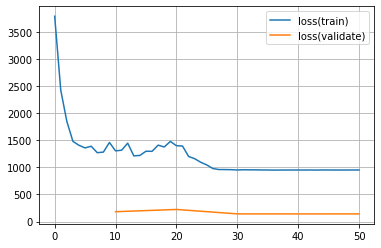

In [4]:
df = pd.read_csv("log_output.csv")
t_loss = df["train_loss"]
v_loss_col = df["val_loss"]

v_loss_x = [10, 20, 30, 40, 50]
v_loss_y = [v_loss_col[9], v_loss_col[19], v_loss_col[29], v_loss_col[39], v_loss_col[49]]

plt.plot(range(51), t_loss[:51], label='loss(train)')
plt.plot(v_loss_x, v_loss_y, label='loss(validate)')
plt.legend()
plt.grid()
plt.show()

以上